In [19]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import os
import zipfile
from tensorflow import keras

# Downloading Dataset
url_normal = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
url_abnormal = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"

# Get File
keras.utils.get_file("CT-0.zip", url_normal, cache_dir=".", cache_subdir="")
keras.utils.get_file("CT-23.zip", url_abnormal, cache_dir=".", cache_subdir="")

# Directory
os.makedirs("MosMedData", exist_ok=True)

# Unziping Dataset
if not os.path.exists("MosMedData/CT-0"):
    print("Unzipping CT-0 data...")
    with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
        z_fp.extractall("./MosMedData/")

if not os.path.exists("MosMedData/CT-23"):
    print("Unzipping CT-23 data...")
    with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
        z_fp.extractall("./MosMedData/")

print(" Data is downloaded and ready!")

1065471431/1065471431 ━━━━━━━━━━━━━━━━━━━━ 783s 1us/step
1045162547/1045162547 ━━━━━━━━━━━━━━━━━━━━ 44s 0us/step
Unzipping CT-0 data...
Unzipping CT-23 data...
 Data is downloaded and ready!


In [3]:
import nibabel as nib
from scipy import ndimage

def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    desired_depth = 32
    desired_width = 64
    desired_height = 64

    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]

    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resizing across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


In [4]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]

# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


In [5]:
# Processing the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

# For the CT scans having presence of viral pneumonia assign 1
# For the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

#  Data setup
def train_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=-1)
    return volume, label

def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=-1)
    return volume, label

train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 16

train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

def get_balanced_model(width=64, height=64, depth=32):
    inputs = keras.Input((width, height, depth, 1))

    # Data Filtering

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu",
                      kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu",
                      kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu",
                      kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)

    x = layers.Dense(units=256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)

    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs, name="3dcnn_balanced")

# Compile and Train
print("Compiling Model")
model = get_balanced_model(width=64, height=64, depth=32)

# learning rate
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Early Stopping
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=60,
    shuffle=True,
    callbacks=[callback],
    verbose=2
)

Compiling Balanced Model...
🚀 STARTING BALANCED RUN...
Epoch 1/60
9/9 - 27s - 3s/step - acc: 0.6000 - loss: 4.4993 - val_acc: 0.5000 - val_loss: 4.5028
Epoch 2/60
9/9 - 1s - 151ms/step - acc: 0.6786 - loss: 4.3739 - val_acc: 0.5000 - val_loss: 4.4461
Epoch 3/60
9/9 - 1s - 152ms/step - acc: 0.7571 - loss: 4.2772 - val_acc: 0.5000 - val_loss: 4.3928
Epoch 4/60
9/9 - 1s - 150ms/step - acc: 0.7500 - loss: 4.1855 - val_acc: 0.5000 - val_loss: 4.3439
Epoch 5/60
9/9 - 1s - 149ms/step - acc: 0.7643 - loss: 4.1058 - val_acc: 0.5000 - val_loss: 4.2987
Epoch 6/60
9/9 - 1s - 149ms/step - acc: 0.7786 - loss: 4.0121 - val_acc: 0.5000 - val_loss: 4.2557
Epoch 7/60
9/9 - 1s - 150ms/step - acc: 0.7857 - loss: 3.9465 - val_acc: 0.5000 - val_loss: 4.1929
Epoch 8/60
9/9 - 1s - 150ms/step - acc: 0.8929 - loss: 3.8476 - val_acc: 0.5000 - val_loss: 4.1695
Epoch 9/60
9/9 - 1s - 149ms/step - acc: 0.8286 - loss: 3.7901 - val_acc: 0.5000 - val_loss: 4.1764
Epoch 10/60
9/9 - 1s - 150ms/step - acc: 0.8643 - loss: 

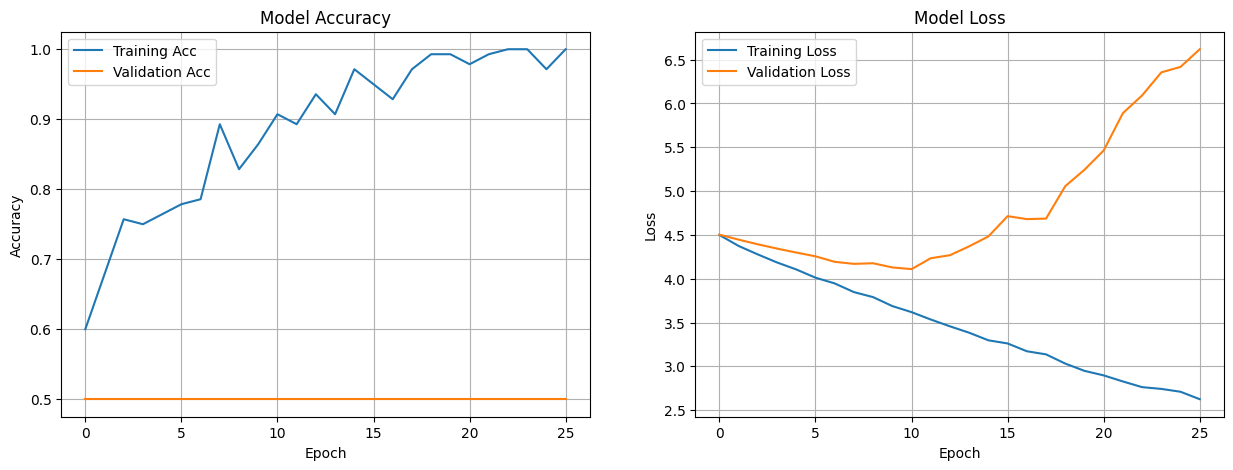

Final Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Actual Label:      Abnormal
Model Prediction:  Abnormal
Confidence:        80.08%


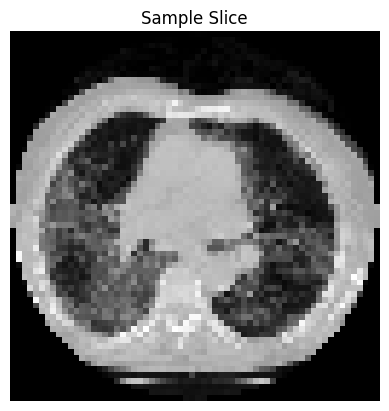

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Ploting the Graphs
history = model.history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
ax1.plot(history["acc"], label="Training Acc")
ax1.plot(history["val_acc"], label="Validation Acc")
ax1.set_title("Model Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history["loss"], label="Training Loss")
ax2.plot(history["val_loss"], label="Validation Loss")
ax2.set_title("Model Loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)
plt.show()

# Final Prediction
print("Final Prediction")
data = validation_dataset.take(1)
images, labels = list(data)[0]
image = images[0]
label = labels[0]

# Predict
prediction = model.predict(tf.expand_dims(image, axis=0))[0]
scores = [1 - prediction[0], prediction[0]]
class_names = ["Normal", "Abnormal"]

print(f"Actual Label:      {class_names[int(label)]}")
print(f"Model Prediction:  {class_names[np.argmax(scores)]}")
print(f"Confidence:        {100 * np.max(scores):.2f}%")

plt.imshow(np.squeeze(image[:, :, 16]), cmap="gray")
plt.title("Sample Slice")
plt.axis("off")
plt.show()